# Rock Paper Scissors - AI
## Model training

### Imports

In [7]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.16.1
Keras version:  3.1.1
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


### Dataset preprocessing

In [8]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'original_data')
dataset_dir = os.path.join(local_dir, 'dataset')
models_dir = os.path.join(local_dir, 'models')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

./dataset\train
    - rock: 580 images
    - paper: 569 images
    - scissors: 600 images
./dataset\val
    - rock: 73 images
    - paper: 71 images
    - scissors: 75 images
./dataset\test
    - rock: 73 images
    - paper: 72 images
    - scissors: 75 images


In [9]:
check_for_duplicates_in_dataset('./dataset')

No duplicates found in dataset
2188 files found in dataset


### Data augmentation

In [10]:
# Image target size
img_rows, img_cols = 224, 224

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')


Found 1749 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


### Model CNN

In [11]:
model_name = 'cnn_simple'
load_model = False

model = create_simple_cnn_model(input_shape=(224, 224, 3), num_classes=3)

if load_model:
    assert os.path.exists(model_path), 'Model not found'
    model = tf.keras.models.load_model(model_path)
    print(f'Model loaded: {model_path}')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,587 (45.64 MB)

 Trainable params: 11,963,587 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
epochs = 150

hist = model.fit(
      train_generator,
      epochs=epochs,
      validation_data=val_generator)


Epoch 1/150


In [7]:
save = True
if save:
    save_model(model, model_name, models_dir, history=hist.history)

Model saved in ./models\simple_cnn_1.h5
History saved in ./models\simple_cnn_1_history.pkl


In [8]:
load_history_from_file = False
if load_history_from_file:
    hist = load_history(model_name, models_dir)

<Figure size 640x480 with 0 Axes>

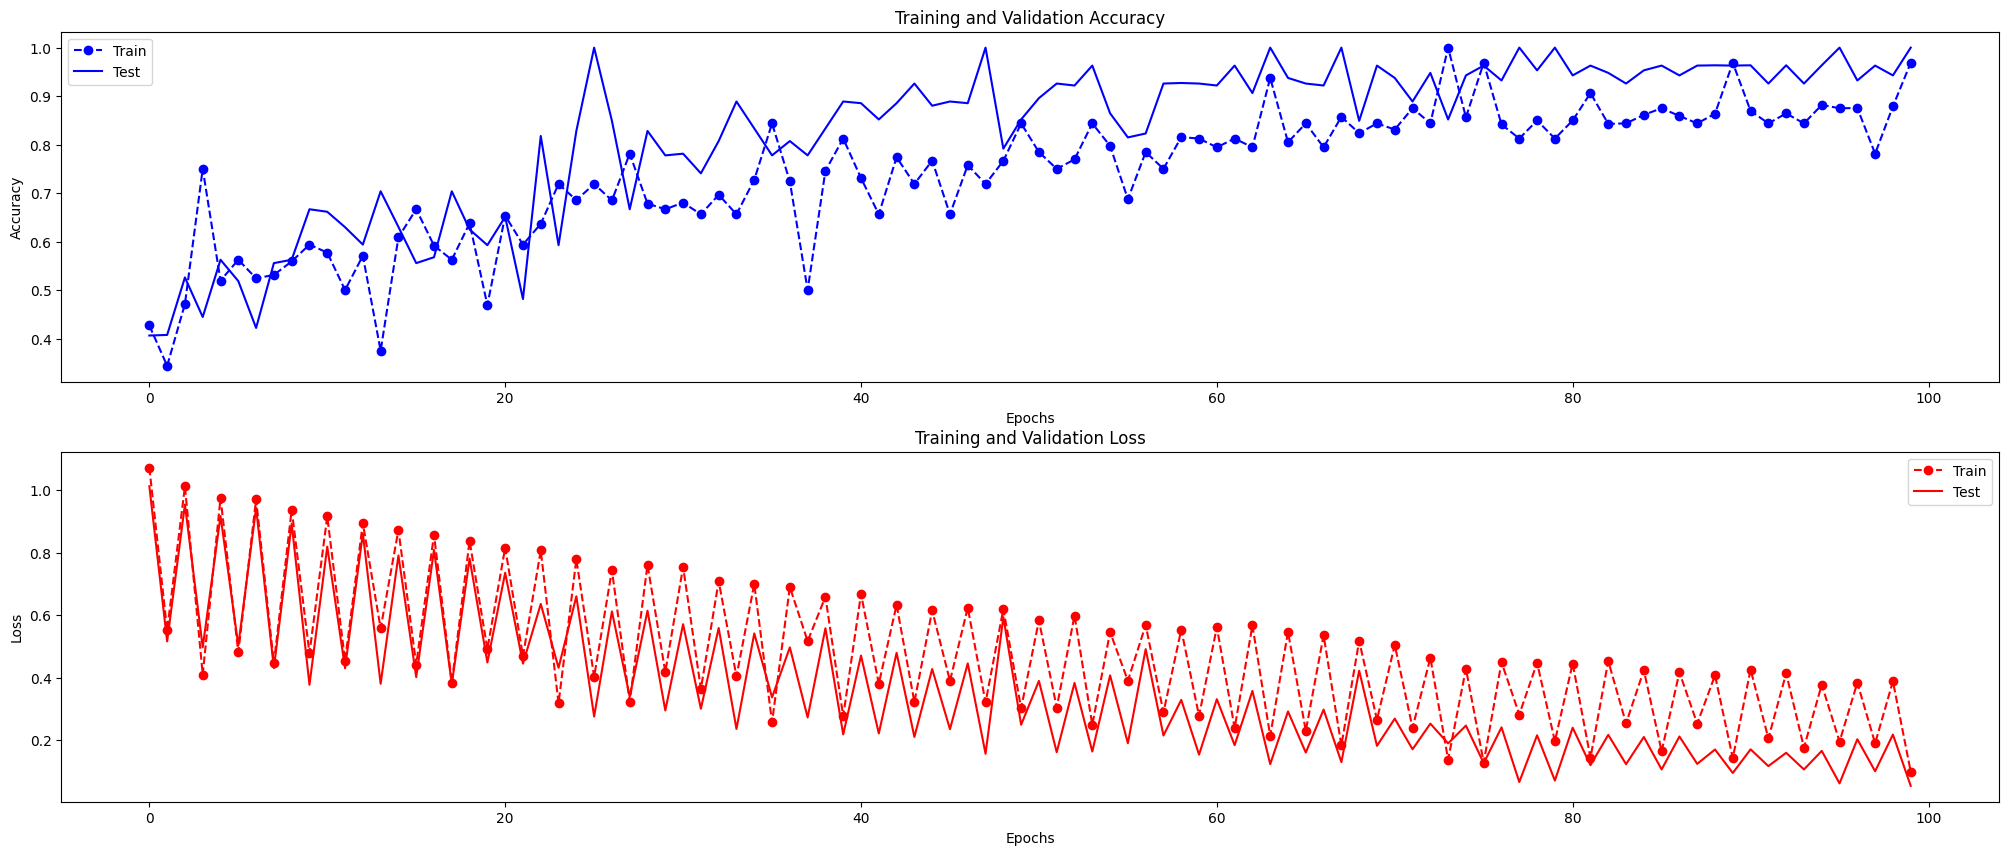

In [9]:
plot_accuracy_and_loss(hist.history)